# MSDM5003 Problem Set 7B
## Wealth Game of S&P500
__Name:__ LIU Jingting

__ID:__ 21128685

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [2]:
# (1)Download S&P500 data
start_date = '2015-11-01'
end_date = '2024-11-01'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date)
sp500_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2015-11-02 00:00:00+00:00,2104.050049,2104.050049,2106.199951,2080.760010,2080.760010,3760020000
2015-11-03 00:00:00+00:00,2109.790039,2109.790039,2116.479980,2097.510010,2102.629883,4272060000
2015-11-04 00:00:00+00:00,2102.310059,2102.310059,2114.590088,2096.979980,2110.600098,4078870000
2015-11-05 00:00:00+00:00,2099.929932,2099.929932,2108.780029,2090.409912,2101.679932,4051890000
2015-11-06 00:00:00+00:00,2099.199951,2099.199951,2101.909912,2083.739990,2098.600098,4369020000
...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,5808.120117,5808.120117,5862.819824,5799.979980,5826.750000,3501280000
2024-10-28 00:00:00+00:00,5823.520020,5823.520020,5842.919922,5823.080078,5833.930176,3691280000


In [3]:
prices = sp500_data['Close'].values

In [4]:
N = 101  # number of agents
S = 2    # number of strategies per agent
M = 3    # memory size
NUM_STATES = 2**M  # number of possible states
BETA = 0.5  # market impact factor

In [5]:
# (2) calculate transaction prices
P_t = np.zeros(len(prices))
prices = prices.flatten()
P_t[0] = prices[0]
for t in range(len(prices)-1):
    P_t[t+1] = prices[t] + BETA * (prices[t+1] - prices[t])

In [6]:
# (3) initialize the input state at 0 to 0
states = np.zeros(len(prices), dtype=int)

## Simulation of the strategies

In [7]:
# (4) randomly generate the strategies with m of the agents
def generate_strategy(num_states):
    strategy = np.random.randint(-1, 2, num_states)  # -1: sell, 0: hold, 1: buy
    while not (1 in strategy and -1 in strategy):  # ensure at least one buy and one sell
        strategy = np.random.randint(-1, 2, num_states)
    return strategy

strategies = np.array([generate_strategy(NUM_STATES) for _ in range(N * S)])

# Initialize the virtual wealth of each strategy
strategy_wealth = np.full(N * S, 5 * prices[0])  

In [8]:
# (5) Initialize the virtual positions of each strategy to be 0
strategy_positions = np.zeros(N * S)

In [9]:
strategy_wealth_history = np.zeros((len(prices), N * S))
strategy_wealth_history[0] = strategy_wealth

In [11]:
# (6) calculate the input states
def calc_input_state(t, prev_state, num_states):
    if t == 0:
        return 0
    b = 0
    if prices[t] - prices[t - 1] > 0:
        b = 1
    return (2 * prev_state + b) % num_states


for t in range(1, len(prices)):
    states[t] = calc_input_state(t, states[t-1], NUM_STATES)    # update state
    for s in range(N * S):
        # (7) calculate the decision
        decision = strategies[s][states[t]]  
        
        # (8) Update the position of each strategy
        position_bound = strategy_wealth[s] / prices[t]
        strategy_positions[s] = max(min(strategy_positions[s] + decision, position_bound), -position_bound)
        
        # Update the virtual wealth of the strategies
        strategy_wealth[s] += strategy_positions[s] * (P_t[t] - P_t[t - 1])
        strategy_wealth_history[t, s] = strategy_wealth[s]

## Simulation of the agents

In [12]:
# (9) initialize the real wealth of agent
agent_wealth = np.full(N, 5 * prices[0])

# (10) Initialize the real positions of each agent 
agent_positions = np.zeros(N)
agent_strategies = np.array([np.random.choice(S * i + np.arange(S), 2, replace=False) for i in range(N)])
agent_wealth_history = np.zeros((len(prices), N))
agent_wealth_history[0] = agent_wealth

In [14]:
# (11) run the simulation for agents
for t in range(1, len(prices)):
    # Update agents
    for i in range(N):
        # following the strategy with the highest virtual wealth
        best_strategy = agent_strategies[i][np.argmax(strategy_wealth[agent_strategies[i]])]
        decision = strategies[best_strategy][states[t]]
        
        # real positions
        position_bound = agent_wealth[i] / prices[t]
        agent_positions[i] = max(min(agent_positions[i] + decision, position_bound), -position_bound)
        
        # real wealth of the agents
        agent_wealth[i] += agent_positions[i] * (P_t[t] - P_t[t - 1])
        agent_wealth_history[t, i] = agent_wealth[i]

## Presentation of results and discussions

In [16]:
# (12) Calculate the best, worst, and average real wealth of the agents at the end of the game
best_wealth = np.max(agent_wealth)
worst_wealth = np.min(agent_wealth)
avg_wealth = np.mean(agent_wealth)

best_wealth, worst_wealth, avg_wealth  # absolute results

(65144.92142312835, 40.37622508574617, 22041.461312804142)

In [17]:
# divide by initial wealth
initial_wealth = 5 * prices[0]
relative_wealth = agent_wealth / initial_wealth
relative_best_wealth = np.max(relative_wealth)
relative_worst_wealth = np.min(relative_wealth)
relative_avg_wealth = np.mean(relative_wealth)

relative_best_wealth, relative_worst_wealth, relative_avg_wealth

(6.192335725037678, 0.0038379529144978446, 2.095146104065385)

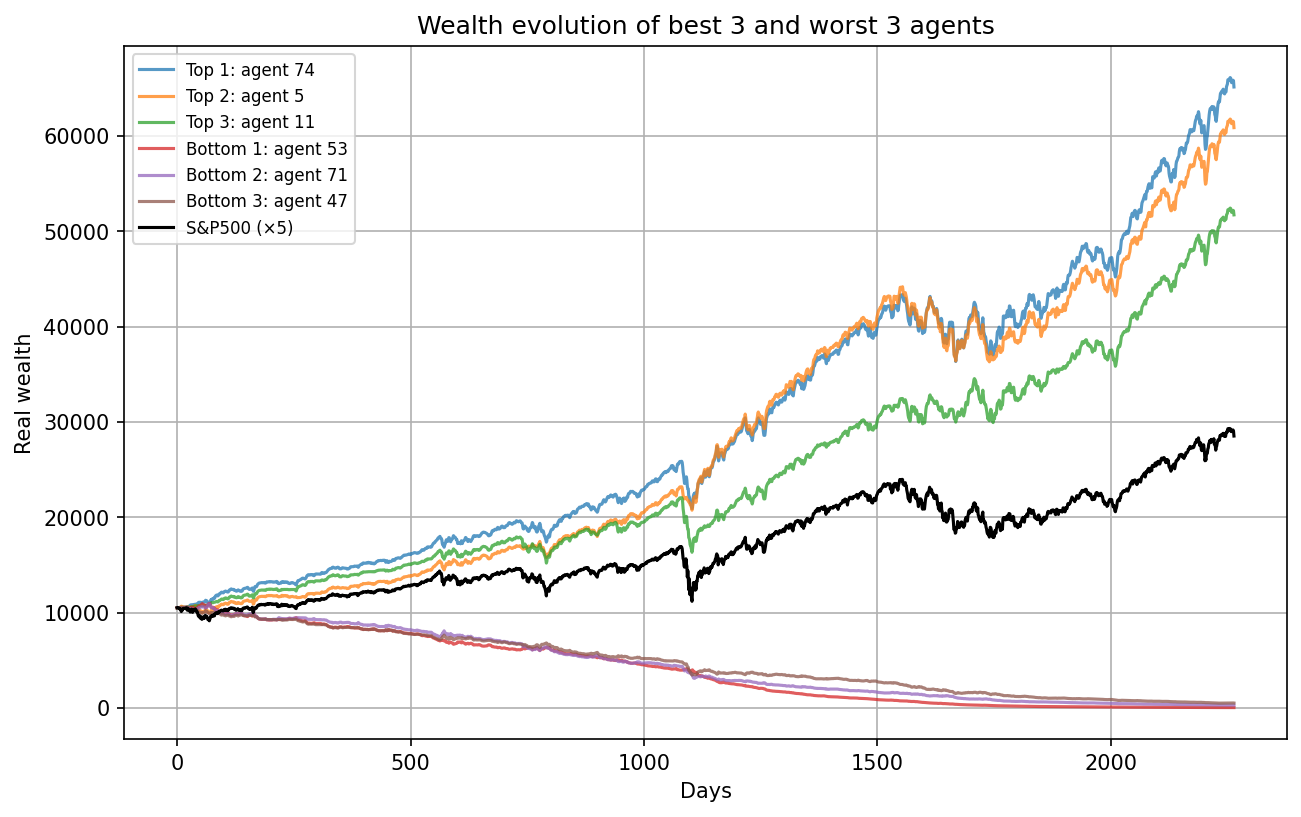

In [31]:
# (13) Find the best 3 and worst 3 agents and plot a graph of their real wealth as a function of time.
best3_indices = np.argsort(agent_wealth)[-3:]
best3_indices = np.flip(best3_indices)
worst3_indices = np.argsort(agent_wealth)[:3]

plt.figure(figsize=(10, 6), dpi=150)
for r, idx in enumerate(best3_indices):
    plt.plot(range(len(prices)), agent_wealth_history[:, idx], label=f'Top {r+1}: agent {idx+1}', alpha=0.75)
for r, idx in enumerate(worst3_indices):
    plt.plot(range(len(prices)), agent_wealth_history[:, idx], label=f'Bottom {r+1}: agent {idx+1}', alpha=0.75)

# # For comparison, also plot the stock index multiplied by 5
plt.plot(range(len(prices)), 5 * prices, label='S&P500 (×5)', color='black')

plt.title('Wealth evolution of best 3 and worst 3 agents')
plt.xlabel('Days')
plt.ylabel('Real wealth')
plt.grid(True)
plt.legend(fontsize=8)
plt.savefig('plot.png')
plt.show()

__(14)__  From the plot above, we can see that in this simulation, the best 3 agents are No.74, 5, 11, their wealth trend was almost the same as that of S&P500. It is crucial for agents to change their strategies to follow the market trend.